## Advanced EDA

https://www.kaggle.com/dgawlik/house-prices-eda

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv("../../Data/Dataset_v2.csv",sep=";")

data['gardens'].unique()

array([nan,  1.])

In [6]:
def categorisation(data,date_cols,target="price"):
    distance = []
    date = []
    numerique = []
    categorique = []
    for col in data.columns:
        if data[col].dtypes == np.object:
            try:
                if str(type(eval(data[col][data[col].first_valid_index()]))) == "<class 'list'>":
                    distance.append(col)
                elif col in date_cols:
                    date.append(col)
                else:
                    categorique.append(col)
            except:
                if col in date_cols:
                    date.append(col)
                else:
                    categorique.append(col)
                
            
        else :
            if col != target:
                numerique.append(col)
                
    return dict({"numerique":numerique,"categorique":categorique,"date":date,"distance":distance})

feat_cat = categorisation(data,["Listing Date"])

C:\Users\USER\AppData\Local\Temp/ipykernel_17052/444471360.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[col].dtypes == np.object:


In [7]:
feat_cat

{'numerique': ['floor_size',
  'bathrooms',
  'levies',
  'rates_and_taxes',
  'bedrooms',
  'kitchens',
  'gardens',
  'sampling'],
 'categorique': ['name',
  'province',
  'city',
  'address',
  'type_of_property',
  'pool',
  'security',
  'pets_allowed',
  'garage'],
 'date': [],
 'distance': ['health',
  'food_and_entertainment',
  'shopping',
  'sports_and_leisure',
  'education',
  'transport_and_public_services']}

In [8]:
class transfo_distance:
    def __init__(self,data,features=None):
        self.data = data
        self.method = "mean"
        ### Get features
        self.distance=[]
        if features is None:
            for col in data.columns:
                if data[col].dtypes == np.object:
                    try:
                        if str(type(eval(data[col][data[col].first_valid_index()]))) == "<class 'list'>":
                            self.distance.append(col)
                    except:
                        pass
        else:
            distance=features
        
        ###Transformations : "mean", "median", "max", "min", "len"
    def transformation(self):
        for feat in self.distance:
            serie = []
            for i in data[feat]:
                if str(i) != "nan":
                    serie.append(self.checker(i,self.method))
                else :
                    serie.append(np.nan)
            self.data[feat] = serie
            
    def checker(self,value,method):
        if method=="mean":
            return (np.array(eval(value))).mean()
        elif method =="median":
            return (np.array(eval(value))).median()
        elif method =="min":
            return (np.array(eval(value))).min()
        elif method =="max":
            return (np.array(eval(value))).max()
        elif method =="len":
            return float(len(eval(value)))
        else:
            raise('choose correct method : "mean", "median", "max", "min", "len"')
    
    def get_data(self,method="mean"):
        self.method=method
        self.transformation()
        return self.data
    

## 1) Numerical

### Get mean of each features distance

In [9]:
trans_dist = transfo_distance(data)
data_T = trans_dist.get_data(method="min")

C:\Users\USER\AppData\Local\Temp/ipykernel_17052/415838001.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[col].dtypes == np.object:


In [10]:
data_T["education"]

0         NaN
1        0.54
2        1.91
3        1.48
4        2.95
         ... 
13661    0.39
13662    0.29
13663    0.42
13664    1.10
13665    1.13
Name: education, Length: 13666, dtype: float64

### Pairplots between price vs numerical features

C:\Users\USER\Anaconda3\envs\deepai\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


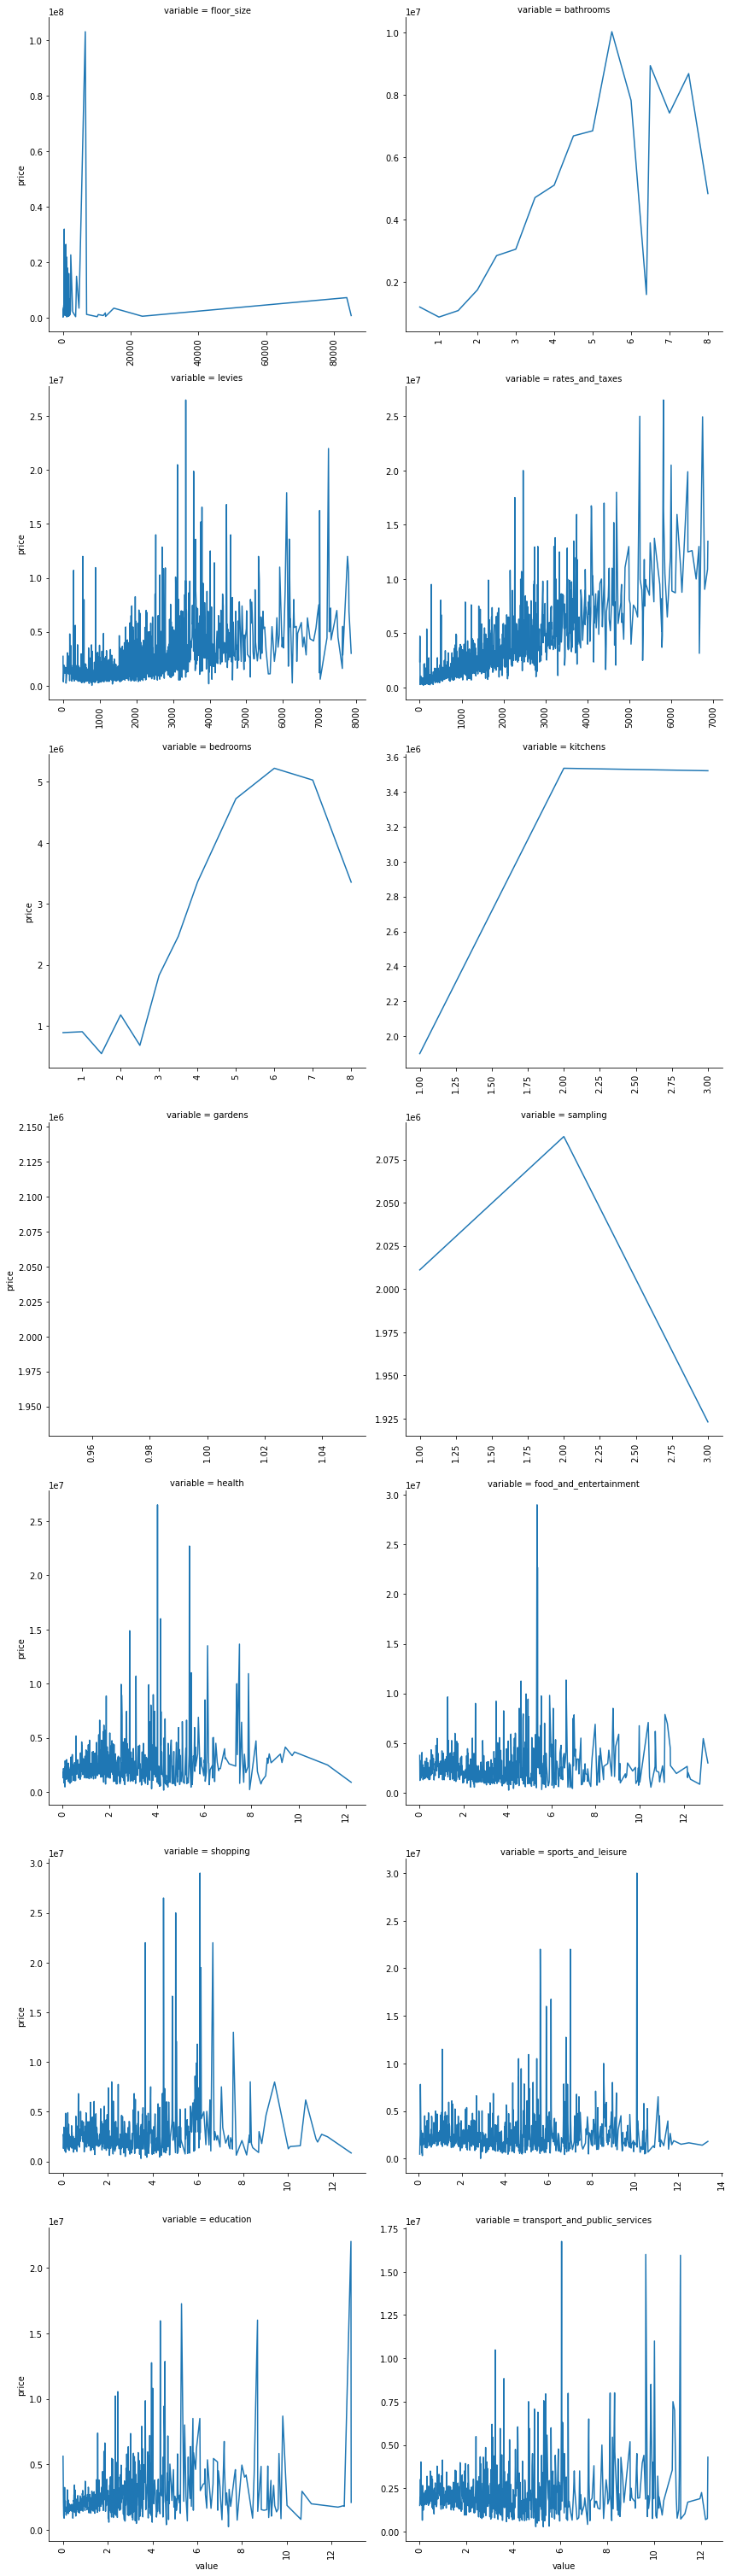

In [11]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
feats = feat_cat["numerique"]+feat_cat["distance"]
f = pd.melt(data_T, id_vars=['price'], value_vars=feats)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=6)
g = g.map(pairplot, "value", "price")

### Correlation matrix

"Spearman" -> Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear.

<AxesSubplot:>

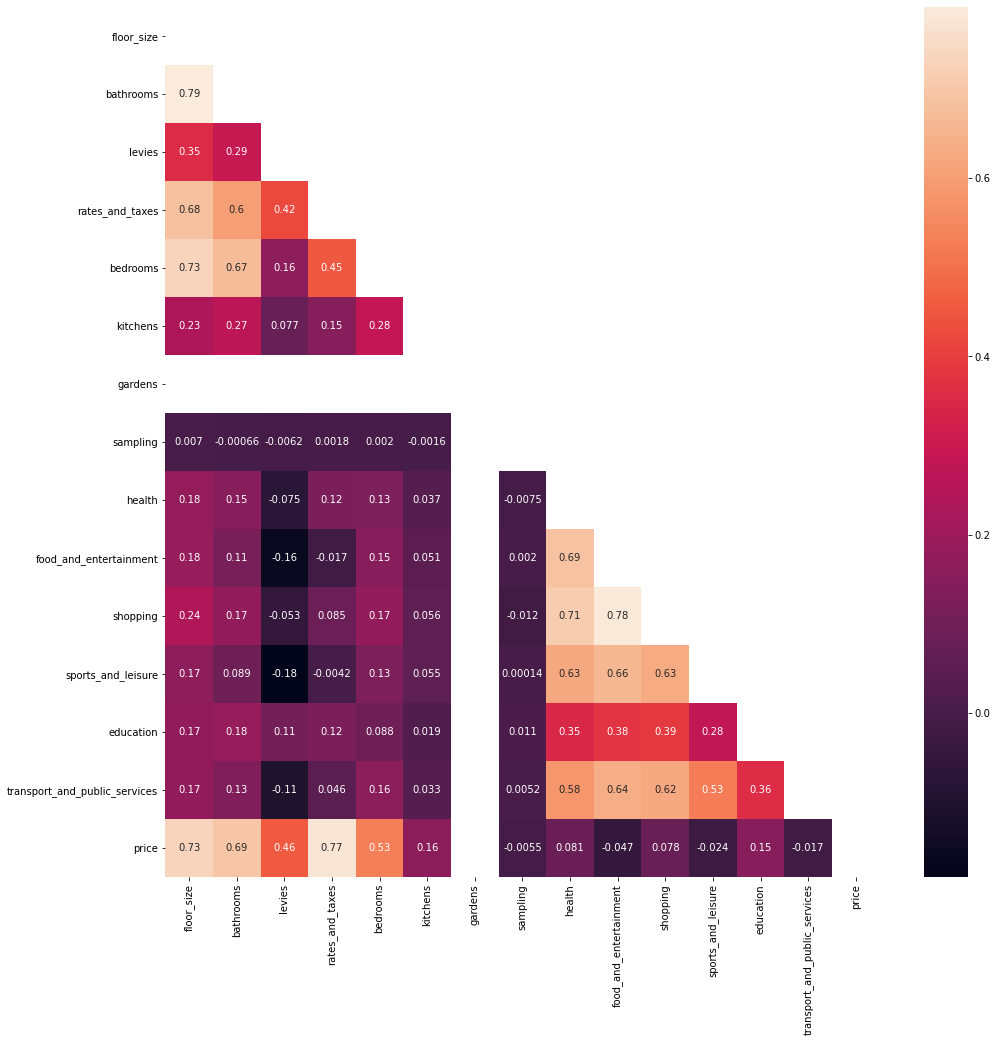

In [12]:
f, axes = plt.subplots(1, 1, figsize=(16, 16), sharex=False)
feats=feats+["price"]
matrix = np.triu(data_T[feats].corr(method='spearman'))
sns.heatmap(data_T[feats].corr(method='spearman'), annot=True,robust=False, mask=matrix, ax=axes)

Features with some correlation with "price" are :
 - bathrooms
 - rates and taxes 
 - floor size 
 - bedrooms
 - levies
 
Notes :
- all distances features (shopping, health, etc) are very correlated each others
- floor size is very correlated to bathrooms, rates and taxes, bedrooms
- bathrooms with rates and taxes, bedrooms also

## 2) Categorical

In [105]:
feat_cat["categorique"]

['name',
 'province',
 'city',
 'address',
 'type_of_property',
 'pool',
 'security',
 'pets_allowed',
 'garage']

### binarisation

In [106]:
for col in data.columns:
    if col == "pets_allowed":
        data[col] = data[col].replace(np.nan,"missing")
    elif col == "pool":
        data[col] = data[col].replace(r".*","y",regex=True)
        data[col] = data[col].replace(r"yy","Yes",regex=True)
        data[col] = data[col].replace(np.nan,"missing")
    elif col == 'security':
        data[col] = data[col].replace(r".*","y",regex=True)
        data[col] = data[col].replace(r"yy","Yes",regex=True)
        data[col] = data[col].replace(np.nan,"missing")
    elif col == "garage":
        data[col] = data[col].replace(r".*","y",regex=True)
        data[col] = data[col].replace(r"yy","Yes",regex=True)
        data[col] = data[col].replace(np.nan,"missing")
    else :
        try :
            data[col] = pd.to_numeric(data[col])
        except:
            if col not in feat_cat["distance"]:
                data[col] = data[col].replace(np.nan,"missing")
                
data["pool"].value_counts()

missing    10259
Yes         3407
Name: pool, dtype: int64

In [110]:
data["security"].value_counts()

missing                         7810
Yes                             5846
Yes\nYes                           8
Yes\nYes\nYes\nYes                 1
Yes\nYes\nYes\nYes\nYes\nYes       1
Name: security, dtype: int64

In [108]:
categoric_f = [
 'province',
 'city',
 'type_of_property',
 'pool',
 'security',
 'pets_allowed',
 'garage']

### not show name and address cause of high cardinality

/home/tokyaxel/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


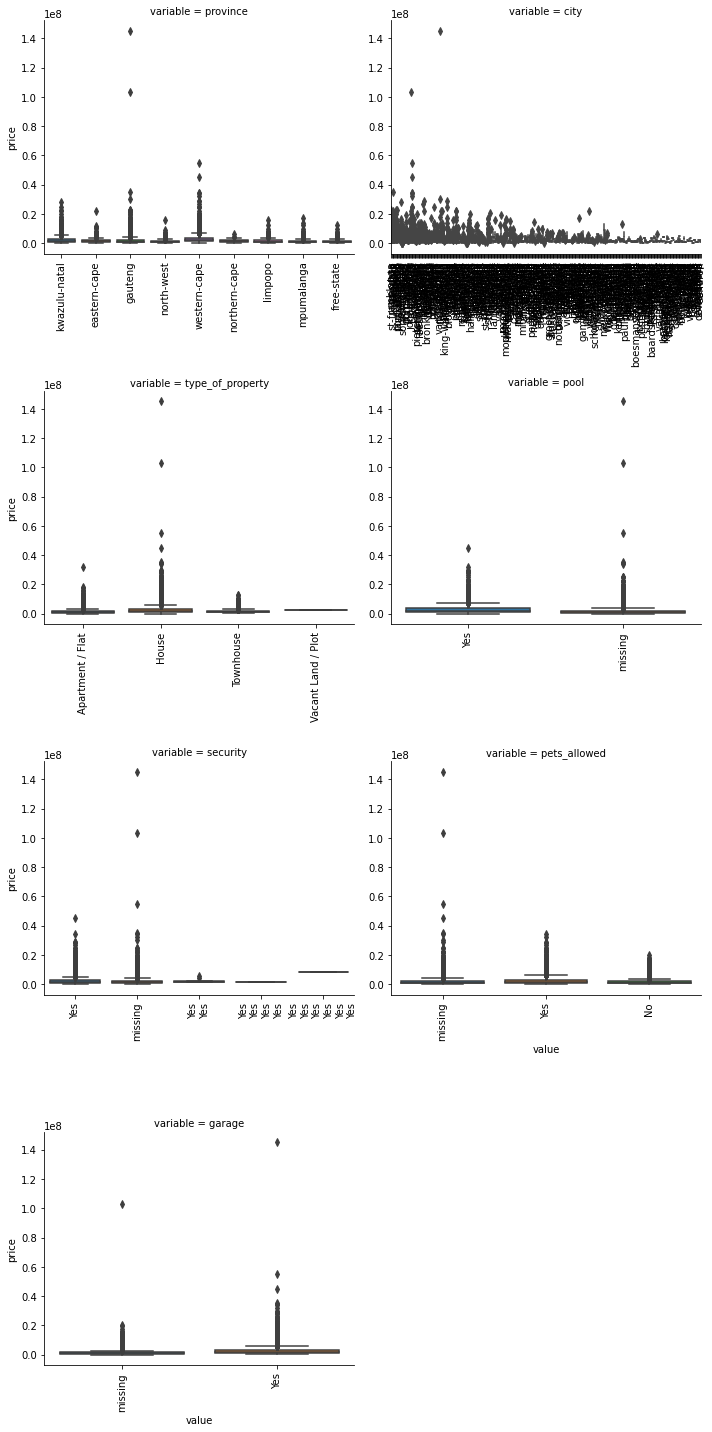

In [109]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(data, id_vars=['price'], value_vars=categoric_f)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")